The lower limit of $T^{0\nu\beta\beta}_{1/2}$ is given by
$$ S(T^{0\nu\beta\beta}_{1/2})  = \text{log}(2) \cdot \epsilon_s \cdot \frac{t \cdot N_0}{S(b)}$$

In [1]:
import os
import time
import numpy  as np
import pandas as pd

from invisible_cities.database.load_db     import RadioactivityData
from invisible_cities.core.system_of_units import kg, dalton, year, mBq, m3, mm

%matplotlib notebook
import matplotlib.pyplot as plt

os.sys.path.append("/Users/gonzalo/NEXT/pybbsens/")
from pybbsens.conflimits import FeldmanCousins

Welcome to JupyROOT 6.24/06


In [2]:
@np.vectorize
def mean_upper_limit(b, cl=90):
    fc = FeldmanCousins(cl)
    return fc.AverageUpperLimit(b)

In [3]:
xenon_density = 78.949 * kg/m3
volume     = np.pi*(490*mm)**2*1200*mm
xenon_mass = (xenon_density * volume)
enrichment = 0.9
N0 = enrichment*(xenon_mass/(136. * dalton))

## background rate

In [4]:
act_df, mceff_df = RadioactivityData("next100")
iceff_df = pd.read_csv("efficiencies_ic_2.4_2.5.csv")
mceff_df = pd.read_csv("mcefficiencies_2.4_2.5.csv")
mceff_df["MCEfficiency"] = mceff_df.nsaved / mceff_df.nsim

index = ["Isotope", "G4Volume"]
iceff_df = iceff_df.set_index(index)
act_df   =   act_df.set_index(index)
mceff_df = mceff_df.set_index(index)

iceff_df["exposure"] = ((iceff_df.nsim/(mceff_df.MCEfficiency*act_df.TotalActivity * mBq))/year)

In [5]:
rates = (act_df.TotalActivity * (mceff_df.nsaved/mceff_df.nsim) * (iceff_df.nreco / iceff_df.nsim) * mBq)
rates = rates * (1/(1/year))
rates = rates.to_frame().rename({0:"rate"}, axis=1)
rates.drop(("0nubb", "ACTIVE"), inplace=True)

In [6]:
# is upper limit?
rates.loc[:, "upperlim"] = False

rates.loc[("214Bi", "ICS")           , "upperlim"] = True
rates.loc[("214Bi", "FIELD_RING")    , "upperlim"] = True
rates.loc[("214Bi", "SIPM_BOARD")    , "upperlim"] = True
rates.loc[("214Bi", "VESSEL")        , "upperlim"] = True
# rates.loc[("214Bi", "SIPM")          , "upperlim"] = True
rates.loc[("214Bi", "OPTICAL_PAD")   , "upperlim"] = True
rates.loc[("214Bi", "SHIELDING_LEAD"), "upperlim"] = True

rates.loc[("208Tl", "ICS")        , "upperlim"] = True
rates.loc[("208Tl", "FIELD_RING") , "upperlim"] = True
rates.loc[("208Tl", "SIPM_BOARD") , "upperlim"] = True
rates.loc[("208Tl", "VESSEL")     , "upperlim"] = True
# rates.loc[("208Tl", "SIPM")       , "upperlim"] = True
rates.loc[("208Tl", "OPTICAL_PAD"), "upperlim"] = True

<IPython.core.display.Javascript object>


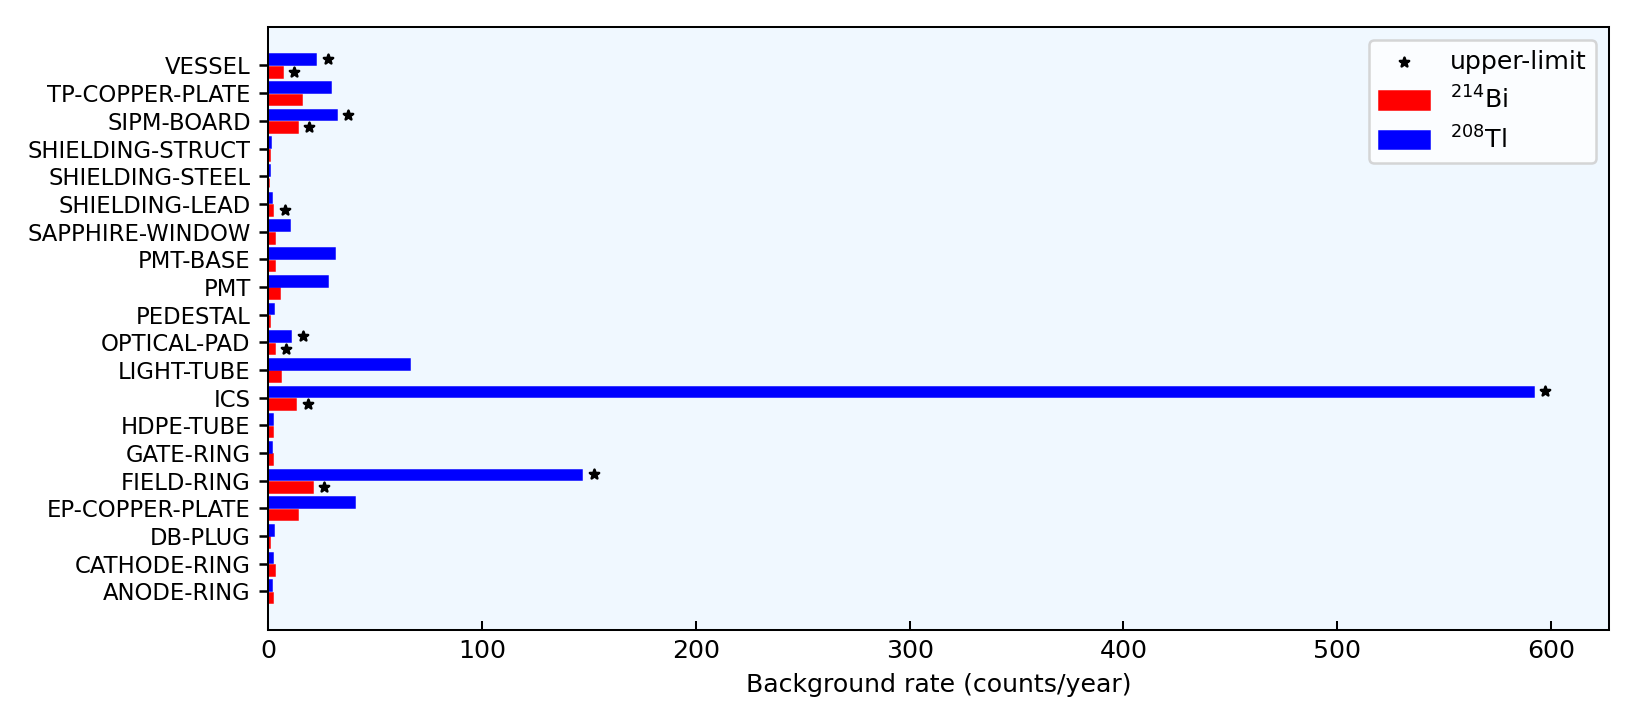

In [7]:
width = 3.5
dx = 10
volumes = rates.index.get_level_values("G4Volume").unique()
volumes = [volume.replace("_", "-") for volume in volumes]
X = np.arange(0, dx*len(volumes), dx)
tick_width = 1

fig = plt.figure(figsize=[9, 4])
ax = fig.add_subplot(111)

# 214Bi
color="r"
b1 = ax.barh( X-width/2.-tick_width/2., rates.loc["214Bi"].rate, height=width
             , color=color, edgecolor=color, label=r"$^{214}$Bi")
# 208Tl
color="b"
b2 = ax.barh( X+width/2.+tick_width/2., rates.loc["208Tl"].rate, height=width
             , color=color, edgecolor=color, label=r"$^{208}$Tl")

# upper limits
du = rates.rate.max()*0.01

isupp = rates.loc["214Bi"].upperlim
ax.scatter( rates.loc["214Bi"].rate.loc[isupp] + du, X[isupp]-width/2.-tick_width/2, marker="*"
           , color="k", s=15, label="upper-limit")

isupp = rates.loc["208Tl"].upperlim
ax.scatter( rates.loc["208Tl"].rate.loc[isupp] + du, X[isupp]+width/2.+tick_width/2, marker="*"
           , color="k", s=15)

# ax.set_xticks(np.arange(0, rates.rate.max(), 10))
ax.set_yticks(X)
ax.set_yticklabels(volumes, rotation=0, fontsize=9)
ax.tick_params(axis='y', width=tick_width)
ax.tick_params(axis='x', direction="in")
ax.ticklabel_format(axis="x", scilimits=(-1, 3))
ax.set_xlabel("Background rate (counts/year)")
ax.legend()

ax.set_facecolor("aliceblue")
fig.tight_layout()

In [8]:
# background rate (counts/year) 2.4 < E < 2.50 MeV
b_Tl = rates.groupby("Isotope").rate.sum().loc["208Tl"]
b_Bi = rates.groupby("Isotope").rate.sum().loc["214Bi"]
b_mu = 900 * 0.1 + 0.08*365

eff_Tl = 0.002431
eff_Bi = 0.010208
eff_mu = 0.01

background_rate = b_Tl*eff_Tl + b_Bi*eff_Bi + b_mu*eff_mu

roi = 2472-2454
conversion_factor = 1/((xenon_mass/kg)*roi)

print("Background rate counts/(year x keV x kg):", format(background_rate*conversion_factor,".3E"))

Background rate counts/(year x keV x kg): 3.711E-03


In [9]:
signal_eff = 0.21
t = 3. * year

background_rates = np.arange(4e-4, 4e-3, .15e-3)

t0 = time.time()
b  = background_rates * (t/year) / conversion_factor
Sb = mean_upper_limit(b, 90)
print("Processing time (min):", (time.time()-t0)/60)

T12_90 = np.log(2.) * (t/year) * signal_eff * N0 / Sb

Processing time (min): 1.8636095841725668


<IPython.core.display.Javascript object>


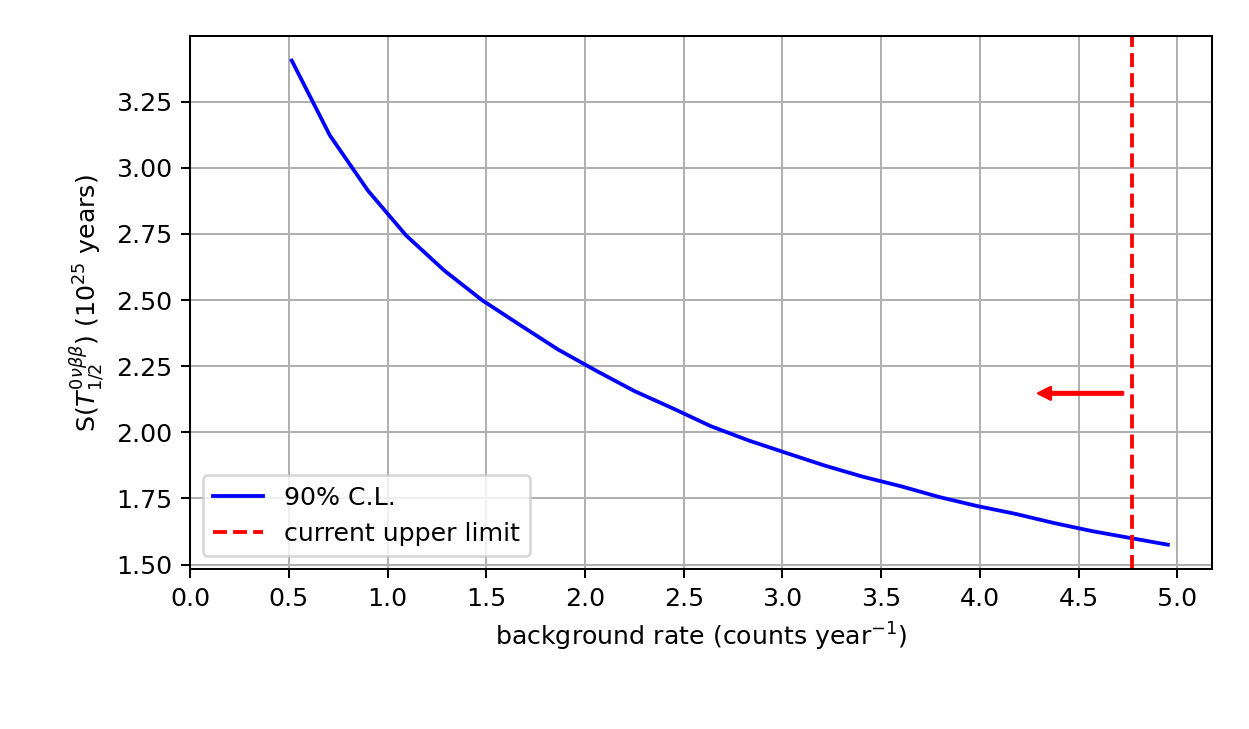

In [10]:
# plot
plt.figure(figsize=[5, 3])

# alpha = 1.64 # CL 90
# T12 = np.log(2) * t * signal_eff * N0 / (np.sqrt(background_rate * t) * alpha)
# plt.plot(t, T12/1e25, color="crimson", label="approx")

# plt.plot(background_rates/1e-3, T12_90/1e25, color=   "blue", label="90% C.L.")
# plt.axvline((background_rate*conversion_factor)/1e-3, linestyle="--", color="r", label="current upper limit")
# plt.annotate( "", xy    =((background_rate*conversion_factor/1e-3)*0.90, np.mean(T12_90/1e25))
#             ,     xytext=((background_rate*conversion_factor/1e-3)*0.99, np.mean(T12_90/1e25))
#             , arrowprops=dict(width=1, headwidth=5, headlength=5, color="r"))


plt.plot(background_rates/conversion_factor, T12_90/1e25, color=   "blue", label="90% C.L.")
plt.axvline(background_rate, linestyle="--", color="r", label="current upper limit")
plt.annotate( "", xy    =((background_rate)*0.90, np.mean(T12_90/1e25))
            ,     xytext=((background_rate)*0.99, np.mean(T12_90/1e25))
            , arrowprops=dict(width=1, headwidth=5, headlength=5, color="r"))


# x
#plt.xlabel(r"background rate ($10^{-3}$ counts keV$^{-1}$kg$^{-1}$year$^{-1}$)")
plt.xticks(np.arange(0, 5.5, 0.5))
plt.xlabel(r"background rate (counts year$^{-1}$)")

# y
plt.ylabel(r"S($T^{0\nu\beta\beta}_{1/2}$) ($10^{25}$ years)")

plt.grid()
plt.legend()
plt.tight_layout()

$T_{1/2}^{2\nu\beta\beta} = 2.34^{+0.80}_{-0.46} (\text{stat.})^{+0.30}_{-0.17}(\text{sys.})\times 10^{21} ~\text{years}$

$S(T_{1/2}^{0\nu\beta\beta}) > 1.6 \times 10^{25} ~\text{years}$

In [ ]:
tmax = 5
t = np.arange(1, tmax+0.25, 0.25)

t0 = time.time()
T12_90 = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(background_rate*t, 90)
T12_95 = np.log(2.) * t * signal_eff * N0 / mean_upper_limit(background_rate*t, 95)

print("Time (min):", (time.time()-t0)/60.)

In [ ]:
# plot
plt.figure(figsize=[4, 3])

# alpha = 1.64 # CL 90
# T12 = np.log(2) * t * signal_eff * N0 / (np.sqrt(background_rate * t) * alpha)
# plt.plot(t, T12/1e25, color="crimson", label="approx")

plt.plot(t, T12_90/1e25, color=   "blue", label="90% C.L.")
plt.plot(t, T12_95/1e25, color="crimson", label="95% C.L.")

plt.xticks(np.arange(1., tmax+0.5, 0.5))
plt.yticks(np.arange(0.5, 2.5, 0.2))
plt.xlabel("exposure (years)")
plt.ylabel(r"$T^{0\nu\beta\beta}_{1/2}$ ($10^{25}$ years)")
plt.grid()
plt.legend()
plt.tight_layout()